In [1]:
import pandas as pd
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import MmhcEstimator
from pgmpy.estimators import K2Score

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.readwrite import BIFReader, BIFWriter

In [3]:
characteristics_df = pd.read_csv('data/characteristics_prepped.csv', encoding='latin1')
places_df = pd.read_csv('data/places_prepped.csv', encoding='latin1')
users_df = pd.read_csv('data/users_prepped.csv', encoding='latin1')
vehicles_df = pd.read_csv('data/vehicles_prepped.csv', encoding='latin1')

## Vehicles + users merge

Vechicles and users table might contain multiple rows for the same Num_Acc id. (Because there might be multiple people or vehicles involved in the accident)

In [4]:
vehicles_df.shape

(1433389, 8)

In [5]:
users_df.shape

(1876005, 13)

In [6]:
vehicles_users_df = pd.merge(vehicles_df, users_df, on='Num_Acc', how='outer', suffixes=('_vehicles', '_users'))

Filter rows that that contains a user-vehicle pair that does not match.

In [7]:
vehicles_users_df = vehicles_users_df[vehicles_users_df['num_veh_vehicles'] == vehicles_users_df['num_veh_users']]

In [8]:
vehicles_users_df.head()

,Num_Acc,Occupants,Mobile Obstacle,Shock,num_veh_vehicles,Vehicle_Category,Fix_obstacle_type,Maneuver_category,Seat,User type,Severity,Sex,Trip,Pedestrian location,Pedestrian action,Pedestrian alone,num_veh_users,Age_range,Safety equipment existence,Safety equipment use
0,200500000001,1,2.0,1.0,A01,8,0,1,1,1,2,1,1,0,0,0,A01,3,1,1
7,200500000001,1,2.0,8.0,B02,8,0,1,1,1,3,2,3,0,0,0,B02,3,1,1
8,200500000001,1,2.0,8.0,B02,8,0,1,2,2,1,1,0,0,0,0,B02,3,1,1
9,200500000001,1,2.0,8.0,B02,8,0,1,4,2,1,1,0,0,0,0,B02,0,3,1
10,200500000001,1,2.0,8.0,B02,8,0,1,5,2,1,1,0,0,0,0,B02,0,1,1


In [9]:
vehicles_users_df['num_veh_vehicles'].isna().sum()

0

In [10]:
vehicles_users_df['num_veh_users'].isna().sum()

0

In [11]:
vehicles_users_df.drop(['num_veh_users', 'num_veh_vehicles'], axis=1, inplace=True)

In [12]:
vehicles_users_df.shape

(1875983, 18)

There are no vehicles without users and no users without vehicles.

## Characteristics + places merge

In [13]:
places_df.shape

(839985, 11)

In [14]:
characteristics_df.shape

(669966, 11)

In [15]:
characteristics_places_df = pd.merge(places_df, characteristics_df, on='Num_Acc', how='inner')

In [16]:
characteristics_places_df.shape

(669966, 21)

## Merge all

In [17]:
merged_df = pd.merge(characteristics_places_df, vehicles_users_df, on='Num_Acc', how='inner')

In [18]:
merged_df.shape

(1491407, 38)

In [19]:
merged_df.head()

,Num_Acc,road_type,traffic_type,num_lanes,bike_lane_type,terrain_type,curve_type,condition,infrastructure,situ,...,User type,Severity,Sex,Trip,Pedestrian location,Pedestrian action,Pedestrian alone,Age_range,Safety equipment existence,Safety equipment use
0,201600000001,3.0,2.0,0.0,0.0,1.0,3.0,1.0,0.0,1.0,...,1,1,2,0,0,0,0,3,1,1
1,201600000001,3.0,2.0,0.0,0.0,1.0,3.0,1.0,0.0,1.0,...,1,3,1,9,0,0,0,1,2,1
2,201600000002,3.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,...,1,3,1,5,0,0,0,4,1,1
3,201600000002,3.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,...,2,3,1,0,0,0,0,1,1,1
4,201600000002,3.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,...,2,3,2,0,0,0,0,4,1,1


In [20]:
merged_df.drop('Num_Acc', axis=1, inplace=True)
merged_df.drop('Municipality', axis=1, inplace=True)
merged_df.drop('Department', axis=1, inplace=True)
merged_df.drop('Date', axis=1, inplace=True)

In [21]:
merged_df = merged_df.apply(pd.to_numeric, downcast="integer")

## Bayes model

In [22]:
merged_df.nunique()

road_type                      7
traffic_type                   5
num_lanes                     11
bike_lane_type                 4
terrain_type                   5
curve_type                     5
condition                     10
infrastructure                 8
situ                           6
school                         3
Lighting                       5
Localisation                   2
Atmospheric conditions         9
Collision type                 7
Holiday                        2
Time_of_day                    4
Regions                       18
Occupants                      5
Mobile Obstacle                7
Shock                         10
Vehicle_Category               8
Fix_obstacle_type              5
Maneuver_category              7
Seat                          10
User type                      4
Severity                       4
Sex                            2
Trip                           7
Pedestrian location            9
Pedestrian action              8
Pedestrian

In [45]:
scoring_method = K2Score(data=merged_df)
est = HillClimbSearch(data=merged_df)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_indegree=4, max_iter=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

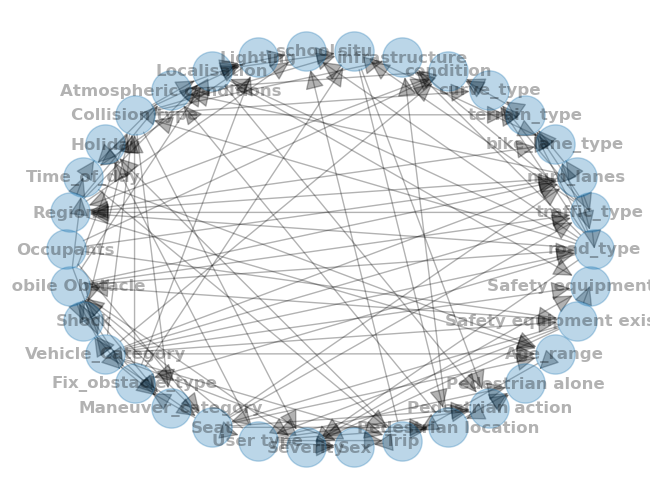

In [50]:
nx.draw_circular(
    estimated_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)

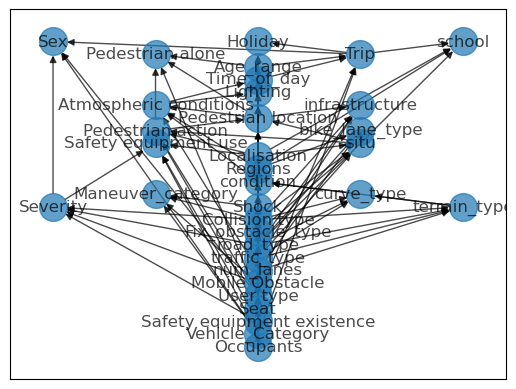

In [51]:
G = estimated_model
#From networkx tutorial for graphing topological order
for layer, nodes in enumerate(nx.topological_generations(G)):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    for node in nodes:
        G.nodes[node]["layer"] = layer

# Compute the multipartite_layout using the "layer" node attribute
pos = nx.multipartite_layout(G, subset_key="layer", align='horizontal')

plt.figure(10)
nx.draw_networkx(G, pos=pos, with_labels=True, arrowsize=10, node_size=400, alpha=0.7)
plt.show()

In [52]:
from pgmpy.models import BayesianNetwork

model = BayesianNetwork(estimated_model)

In [53]:
from pgmpy.estimators import BayesianEstimator
model.fit(merged_df, estimator=BayesianEstimator)

In [56]:
model.save("model_indegree4.xml", filetype="xmlbif")

In [ ]:
model.cpds

### Gibbs Sampling

In [58]:
model_l = BayesianNetwork.load("model_indegree4.xml", filetype="xmlbif")

In [70]:
gibbs_chain.cardinalities

{'intel': 2, 'sat': 2}

In [ ]:
from pgmpy.sampling import GibbsSampling

gibbs_chain = GibbsSampling(model_l)

In [71]:
gibbs_chain.sample(size=1)

0it [00:00, ?it/s]

,intel,sat
0,0,0


### Min-max hill climb

Copied from pgmpy's source to tweak a few things and analyse how the code works.

In [22]:
from pgmpy.base import UndirectedGraph
from pgmpy.estimators import BDeuScore, HillClimbSearch, StructureEstimator
from pgmpy.estimators.CITests import chi_square
from pgmpy.independencies import IndependenceAssertion, Independencies
from pgmpy.models import BayesianNetwork
from pgmpy.utils.mathext import powerset

class MmhcEstimator(StructureEstimator):
    """
    Implements the MMHC hybrid structure estimation procedure for
    learning BayesianNetworks from discrete data.

    Parameters
    ----------
    data: pandas DataFrame object
        dataframe object where each column represents one variable.
        (If some values in the data are missing the data cells should be set to `numpy.NaN`.
        Note that pandas converts each column containing `numpy.NaN`s to dtype `float`.)

    state_names: dict (optional)
        A dict indicating, for each variable, the discrete set of states (or values)
        that the variable can take. If unspecified, the observed values in the data set
        are taken to be the only possible states.

    References
    ----------
    Tsamardinos et al., The max-min hill-climbing Bayesian network structure learning algorithm (2005)
    http://www.dsl-lab.org/supplements/mmhc_paper/paper_online.pdf
    """

    def __init__(self, data, **kwargs):
        super(MmhcEstimator, self).__init__(data, **kwargs)

    def estimate(self, scoring_method=None, tabu_length=10, significance_level=0.01):
        """
        Estimates a BayesianNetwork for the data set, using MMHC. First estimates a
        graph skeleton using MMPC and then orients the edges using score-based local
        search (hill climbing).

        Parameters
        ----------
        significance_level: float, default: 0.01
            The significance level to use for conditional independence tests in the data set. See `mmpc`-method.

        scoring_method: instance of a Scoring method (default: BDeuScore)
            The method to use for scoring during Hill Climb Search. Can be an instance of any of the
            scoring methods implemented in pgmpy.

        tabu_length: int
            If provided, the last `tabu_length` graph modifications cannot be reversed
            during the search procedure. This serves to enforce a wider exploration
            of the search space. Default value: 100.

        Returns
        -------
        Estimated model: pgmpy.base.DAG
            The estimated model without the parameterization.

        References
        ----------
        Tsamardinos et al., The max-min hill-climbing Bayesian network structure learning algorithm (2005),
        Algorithm 3
        http://www.dsl-lab.org/supplements/mmhc_paper/paper_online.pdf

        Examples
        --------
        >>> import pandas as pd
        >>> import numpy as np
        >>> from pgmpy.estimators import MmhcEstimator
        >>> data = pd.DataFrame(np.random.randint(0, 2, size=(2500, 4)), columns=list('XYZW'))
        >>> data['sum'] = data.sum(axis=1)
        >>> est = MmhcEstimator(data)
        >>> model = est.estimate()
        >>> print(model.edges())
        [('Z', 'sum'), ('X', 'sum'), ('W', 'sum'), ('Y', 'sum')]
        """
        if scoring_method is None:
            scoring_method = BDeuScore(self.data, equivalent_sample_size=10)

        skel = self.mmpc(significance_level)

        hc = HillClimbSearch(self.data)

        model = hc.estimate(
            scoring_method=scoring_method,
            white_list=skel.to_directed().edges(),
            tabu_length=tabu_length,
        )

        return model

    def mmpc(self, significance_level=0.01):
        """Estimates a graph skeleton (UndirectedGraph) for the data set, using then
        MMPC (max-min parents-and-children) algorithm.

        Parameters
        ----------
        significance_level: float, default=0.01
            The significance level to use for conditional independence tests in the data set.

            `significance_level` is the desired Type 1 error probability of
            falsely rejecting the null hypothesis that variables are independent,
            given that they are. The lower `significance_level`, the less likely
            we are to accept dependencies, resulting in a sparser graph.

        Returns
        -------
        skeleton: pgmpy.base.UndirectedGraph
            An estimate for the undirected graph skeleton of the BN underlying the data.

        seperating_sets: dict
            A dict containing for each pair of not directly connected nodes a
            seperating set ("witnessing set") of variables that makes then
            conditionally independent. (needed for edge orientation)

        References
        ----------
        Tsamardinos et al., The max-min hill-climbing Bayesian network structure
        learning algorithm (2005), Algorithm 1 & 2
        http://www.dsl-lab.org/supplements/mmhc_paper/paper_online.pdf

        Examples
        --------
        >>> import pandas as pd
        >>> import numpy as np
        >>> from pgmpy.estimators import MmhcEstimator
        >>> data = pd.DataFrame(np.random.randint(0, 2, size=(5000, 5)), columns=list('ABCDE'))
        >>> data['F'] = data['A'] + data['B'] + data ['C']
        >>> est = PC(data)
        >>> skel, sep_sets = est.estimate_skeleton()
        >>> skel.edges()
        [('A', 'F'), ('B', 'F'), ('C', 'F')]
        >>> # all independencies are unconditional:
        >>> sep_sets
        {('D', 'A'): (), ('C', 'A'): (), ('C', 'E'): (), ('E', 'F'): (), ('B', 'D'): (),
         ('B', 'E'): (), ('D', 'F'): (), ('D', 'E'): (), ('A', 'E'): (), ('B', 'A'): (),
         ('B', 'C'): (), ('C', 'D'): ()}
        >>> data = pd.DataFrame(np.random.randint(0, 2, size=(5000, 3)), columns=list('XYZ'))
        >>> data['X'] += data['Z']
        >>> data['Y'] += data['Z']
        >>> est = PC(data)
        >>> skel, sep_sets = est.estimate_skeleton()
        >>> skel.edges()
        [('X', 'Z'), ('Y', 'Z')]
        >>> # X, Y dependent, but conditionally independent given Z:
        >>> sep_sets
        {('X', 'Y'): ('Z',)}
        """

        nodes = self.state_names.keys()

        def assoc(X, Y, Zs):
            """Measure for (conditional) association between variables. Use negative
            p-value of independence test.
            """
            return 1 - chi_square(X, Y, Zs, self.data, boolean=False)[1]

        def min_assoc(X, Y, Zs):
            "Minimal association of X, Y given any subset of Zs."
            return min(assoc(X, Y, Zs_subset) for Zs_subset in powerset(Zs))

        def max_min_heuristic(X, Zs):
            "Finds variable that maximizes min_assoc with `node` relative to `neighbors`."
            max_min_assoc = 0
            best_Y = None

            for Y in set(nodes) - set(Zs + [X]):
                min_assoc_val = min_assoc(X, Y, Zs)
                if min_assoc_val >= max_min_assoc:
                    best_Y = Y
                    max_min_assoc = min_assoc_val

            return (best_Y, max_min_assoc)

        # Find parents and children for each node
        neighbors = dict()
        for node in nodes:
            print("-----------------------------------")
            print("NODE:", node)
            neighbors[node] = []

            # Forward Phase
            while True:
                new_neighbor, new_neighbor_min_assoc = max_min_heuristic(
                    node, neighbors[node]
                )
                print("forward step neighbors size", len(neighbors[node]), new_neighbor_min_assoc)
                if new_neighbor_min_assoc > 0:
                    neighbors[node].append(new_neighbor)
                else:
                    break

            # Backward Phase
            for neigh in neighbors[node]:
                other_neighbors = [n for n in neighbors[node] if n != neigh]
                print("backward step", neigh, "other_neighbors size", len(other_neighbors))
                for sep_set in powerset(other_neighbors):
                    if chi_square(
                        X=node,
                        Y=neigh,
                        Z=sep_set,
                        data=self.data,
                        significance_level=significance_level,
                    ):
                        neighbors[node].remove(neigh)
                        break

        # correct for false positives
        for node in nodes:
            for neigh in neighbors[node]:
                if node not in neighbors[neigh]:
                    neighbors[node].remove(neigh)

        skel = UndirectedGraph()
        skel.add_nodes_from(nodes)
        for node in nodes:
            skel.add_edges_from([(node, neigh) for neigh in neighbors[node]])

        return skel

In [49]:
cols = merged_df.columns[0:10].tolist()

In [50]:
cols

['road_type',
 'traffic_type',
 'num_lanes',
 'bike_lane_type',
 'terrain_type',
 'curve_type',
 'condition',
 'infrastructure',
 'situ',
 'school']

In [ ]:
mmest = MmhcEstimator(data=merged_df[cols])
mmest.mmpc()

In [ ]:
model = mmest.estimate()

In [ ]:
merged_df.columns

In [ ]:
merged_df.nunique()